Все ДЗ состоит из двух частей. Первая часть более развернутая и экспериментальная - в ней вам нужно будет обучить архитектуру для задачи Image Classification. Вам нужно реализовать архитектуру, обучить ее, а так же выполнить некоторые дополнительные задания. Вторая часть более простая - вам просто требуется разобраться во фреймворке и запустить его на данных.

In [102]:
!rm -r "./resnet50_local"
!rm -r "./resnet50_torch"
!rm -r "./vgg16"
!rm -r "./mobilenet"

In [4]:
# libs

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from collections import Counter
from torch.hub import load_state_dict_from_url
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

# ДЗ 2.1 Image classification. 16 баллов.

В качестве датасета будет использовать вот этот - https://www.kaggle.com/datasets/slothkong/10-monkey-species

In [104]:
# !kaggle datasets download -d slothkong/10-monkey-species

In [105]:
# import zipfile

# with zipfile.ZipFile("10-monkey-species.zip", "r") as zip_ref:
#     zip_ref.extractall()

# Dataset

Add Augmentation

В качестве аугментаций данных выбраны случайный кроп, случайные первороты по горизонтали и вертикали изображения.

При чины выбора данных аугментаций просты. После просмотра изображений не было выявлено сильных измений в цвете, а
обезьяны могут быть в разных положениях.

In [106]:
train_transforms = v2.Compose(
    [
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.1),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [107]:
valid_transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [108]:
train_ds = ImageFolder("./data/training/training/", transform=train_transforms)
test_ds = ImageFolder("./data/validation/validation/", transform=valid_transforms)

In [109]:
train_cnt = Counter(train_ds.targets)
test_cnt = Counter(test_ds.targets)
print(train_cnt)
print(test_cnt)

Counter({3: 122, 7: 114, 5: 113, 1: 111, 2: 110, 6: 106, 8: 106, 0: 105, 4: 105, 9: 105})
Counter({3: 30, 1: 28, 5: 28, 7: 28, 2: 27, 8: 27, 0: 26, 4: 26, 6: 26, 9: 26})


# Dataloader

In [110]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

## ResNet50

Реализуйте ResNet50. Чтобы вспомнить архитектуру, обратитесь к лекции + оригинальной статье авторов+google.

Если хотите реализовать что-то поинтереснее (ViT) - делайте, будет учтено.

Что будет оцениваться в задании:
* ResNet50 from scratch **6 баллов**
* добавьте аугментаций, напишите краткое саммари почему выбрали именно такой набор аугментаций. **1 балл**
* дописать логику обучения модели **2 балла**
* дописать логику тестирования модели **1 балл**
* возьмите еще 2 модели из зоопарка моделей [torchvision](https://pytorch.org/vision/stable/models.html?), зафайнтюньте на наш датасет. Сравните их между собой и вашей реализацией. **4 балла**
* обязательно в конце напишите общий отчет о проделанной работе. Для лучшей модели проведите анализ метрик и ошибок, постройте confusion_matrix и classification report **2 балла**
* графики обучения обязательно должны присутсвовать

**NOTE**: рядом лежит ноутбук с baseline solution, вы можете отталкиваться от него, если хотите.

In [111]:
def conv_3x3(in_channels, out_channels, stride=1, dilation=1, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        dilation=dilation,
        groups=groups,
        bias=False,
    )


def conv_1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=1, stride=stride, bias=False
    )

In [112]:
class BottleNeck(nn.Module):
    def __init__(
        self, in_channels, channels, stride=1, groups=1, dilation=1, downsample=None
    ):
        super(BottleNeck, self).__init__()
        norm_layer = nn.BatchNorm2d
        width = int(channels * groups)

        self.conv1 = conv_1x1(in_channels, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv_3x3(
            width, width, stride=stride, groups=groups, dilation=dilation
        )
        self.bn2 = norm_layer(width)
        self.conv3 = conv_1x1(width, channels * 4)
        self.bn3 = norm_layer(channels * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        skip_connection = x
        if self.downsample is not None:
            skip_connection = self.downsample(x)

        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output += skip_connection
        output = self.relu(output)

        return output

In [113]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._build_layer(channels=64, num_blocks=3)
        self.layer2 = self._build_layer(channels=128, num_blocks=4, stride=2)
        self.layer3 = self._build_layer(channels=256, num_blocks=6, stride=2)
        self.layer4 = self._build_layer(channels=512, num_blocks=3, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1000)

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(
                    module.weight, mode="fan_out", nonlinearity="relu"
                )
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.max_pool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

    def _build_layer(self, channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * 4:
            
            downsample = nn.Sequential(
                conv_1x1(self.in_channels, channels * 4, stride),
                nn.BatchNorm2d(channels * 4),
            )
        blocks = []
        blocks.append(
            BottleNeck(self.in_channels, channels, stride=stride, downsample=downsample)
        )
        self.in_channels = channels * 4
        for _ in range(1, num_blocks):
            blocks.append(BottleNeck(self.in_channels, channels))

        return nn.Sequential(*blocks)

In [114]:
def resnet50(pretrained=False):
    model = ResNet50()
    if pretrained:
        state_dict = load_state_dict_from_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth", progress=True
        )
        model.load_state_dict(state_dict)
    return model

# Train

In [115]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, num_classes, pretrained=False, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        models = {
            "resnet50_torch": (
                torchvision.models.resnet50(pretrained=pretrained),
                2048,
            ),
            "resnet50_local": (resnet50(pretrained=pretrained), 2048),
            "vgg16": (torchvision.models.vgg16(pretrained=pretrained), 4096),
            "mobilenet": (torchvision.models.mobilenet_v2(pretrained=pretrained), 1280),
        }
        self.lr = lr
        self.num_classes = num_classes
        self.model = models[model][0]
        in_feat = models[model][1]
        if model == "resnet50_local" or model == "resnet50_torch":
            self.model.fc = nn.Linear(in_feat, self.num_classes)
        elif model == "vgg16":
            self.model.classifier[6] = nn.Linear(in_feat, self.num_classes)
        elif model == "mobilenet":
            self.model.classifier[1] = nn.Linear(in_feat, self.num_classes)

        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch

        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)

        self.log("train_loss", loss.item(), logger=True)
        self.log("train_acc", acc, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        preds = self(x)

        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)

        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

In [116]:
def plot_learning_curves(name_model):
    data = pd.read_csv(f"./{name_model}/lightning_logs/version_0/metrics.csv")
    data = data.groupby("epoch").agg("max")
    epochs = list(data.index)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(epochs, data.train_acc, label="train")
    axs[0].plot(epochs, data.val_acc, label="valid")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    axs[1].plot(epochs, data.train_loss, label="train")
    axs[1].plot(epochs, data.val_loss, label="valid")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    fig.suptitle(f"Learning process of {name_model}", fontsize=16)

    plt.show()

In [117]:
def train_model(name_model: str, num_classes, pretrained=True, lr=1e-3):
    model = TrainModel(
        name_model, num_classes=num_classes, pretrained=pretrained, lr=lr
    )
    trainer_args = {
        "accelerator": "gpu",
        "max_epochs": 10,
        "log_every_n_steps": 18,
        "default_root_dir": name_model,
    }
    trainer = pl.Trainer(**trainer_args)
    trainer.fit(model, train_dl, test_dl)

    plot_learning_curves(name_model)

    return model

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


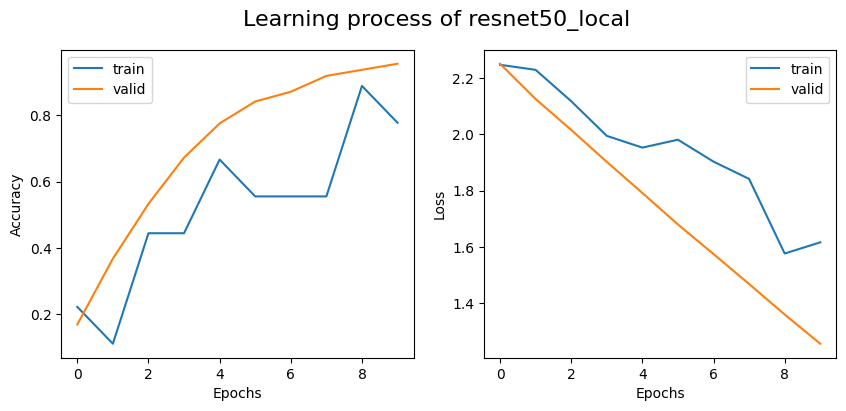

In [118]:
torch.manual_seed(42)
resnet50_local = train_model("resnet50_local", 10)

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


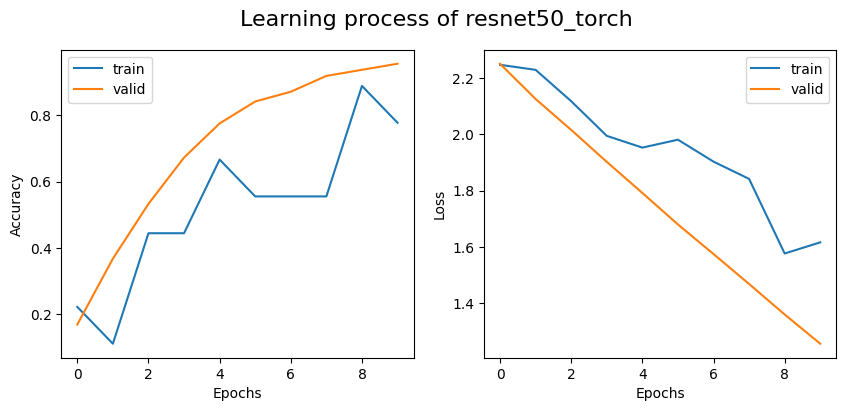

In [119]:
torch.manual_seed(42)
resnet50_torch = train_model("resnet50_torch", 10)

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


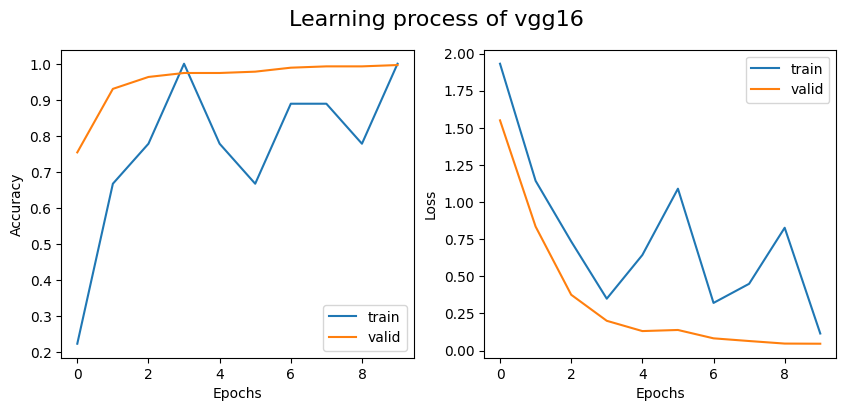

In [120]:
torch.manual_seed(42)
vgg16 = train_model("vgg16", 10)

/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dimalkevich/miniconda3/envs/science/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


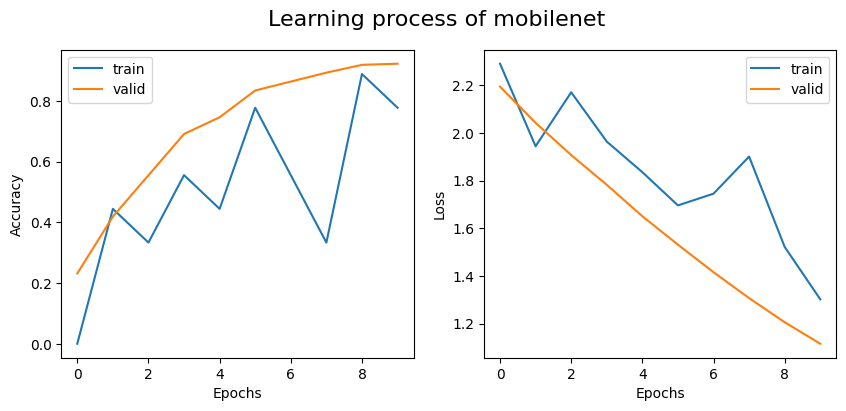

In [121]:
torch.manual_seed(42)
mobilenet = train_model("mobilenet", 10)

# Test and metrics

In [122]:
def testing(model, dataloader):
    model.eval()
    real_labels = []
    predicted_labels = []
    accuracy = Accuracy(task="multiclass", num_classes=10)
    with torch.no_grad():
        for data, target in dataloader:
            preds = model(data)
            predicted_labels.append(torch.argmax(preds, dim=1))
            real_labels.append(target)
    y_true = torch.cat(real_labels)
    y_pred = torch.cat(predicted_labels)
    
    print("Accuracy :", accuracy(y_pred, y_true).item())
    
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    print("###CONFUSION MATRIX###")
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    disp.plot()
    
    plt.show()
    
    print("###CLASSIFICATION REPORT###")
    print(classification_report(y_true, y_pred, labels=class_labels))

### Local ResNet50

Accuracy : 0.9558823704719543
###CONFUSION MATRIX###


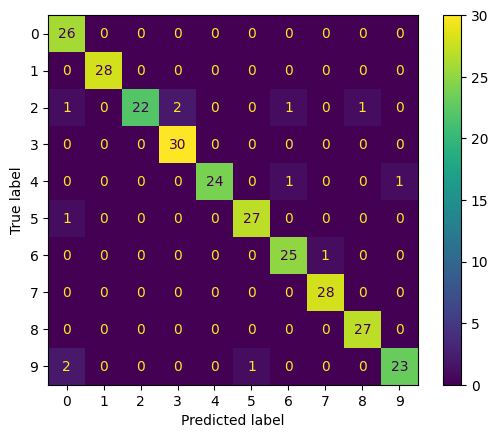

###CLASSIFICATION REPORT###
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        26
           1       1.00      1.00      1.00        28
           2       1.00      0.81      0.90        27
           3       0.94      1.00      0.97        30
           4       1.00      0.92      0.96        26
           5       0.96      0.96      0.96        28
           6       0.93      0.96      0.94        26
           7       0.97      1.00      0.98        28
           8       0.96      1.00      0.98        27
           9       0.96      0.88      0.92        26

    accuracy                           0.96       272
   macro avg       0.96      0.95      0.95       272
weighted avg       0.96      0.96      0.96       272



In [123]:
testing(resnet50_local, test_dl)

### PyTorch ResNet50

Accuracy : 0.9558823704719543
###CONFUSION MATRIX###


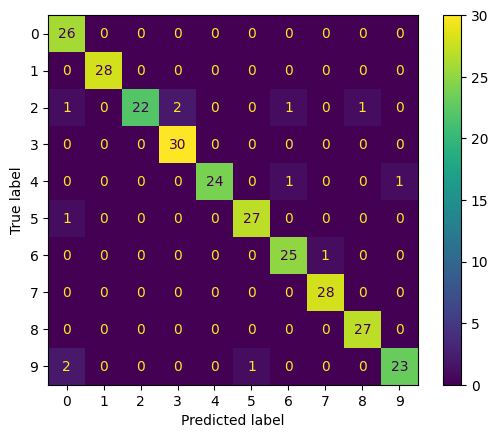

###CLASSIFICATION REPORT###
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        26
           1       1.00      1.00      1.00        28
           2       1.00      0.81      0.90        27
           3       0.94      1.00      0.97        30
           4       1.00      0.92      0.96        26
           5       0.96      0.96      0.96        28
           6       0.93      0.96      0.94        26
           7       0.97      1.00      0.98        28
           8       0.96      1.00      0.98        27
           9       0.96      0.88      0.92        26

    accuracy                           0.96       272
   macro avg       0.96      0.95      0.95       272
weighted avg       0.96      0.96      0.96       272



In [124]:
testing(resnet50_torch, test_dl)

### VGG16

Accuracy : 0.9963235259056091
###CONFUSION MATRIX###


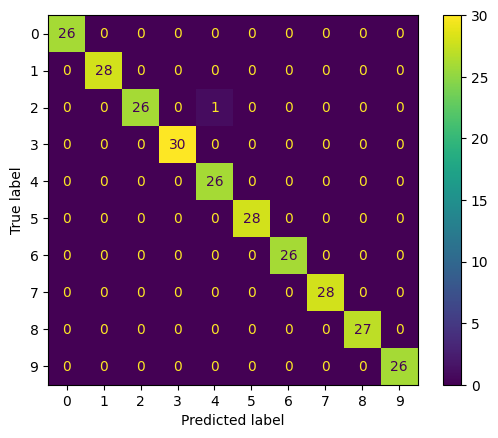

###CLASSIFICATION REPORT###
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        28
           2       1.00      0.96      0.98        27
           3       1.00      1.00      1.00        30
           4       0.96      1.00      0.98        26
           5       1.00      1.00      1.00        28
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        27
           9       1.00      1.00      1.00        26

    accuracy                           1.00       272
   macro avg       1.00      1.00      1.00       272
weighted avg       1.00      1.00      1.00       272



In [125]:
testing(vgg16, test_dl)

### MobileNet

Accuracy : 0.9227941036224365
###CONFUSION MATRIX###


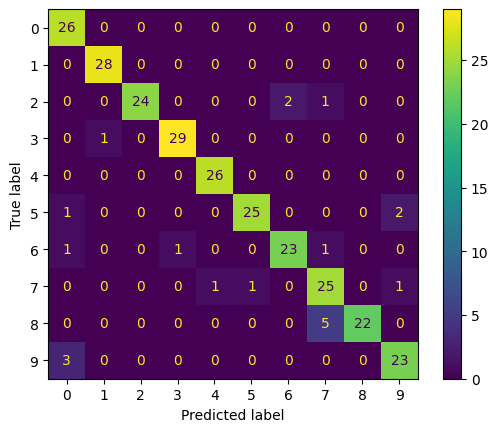

###CLASSIFICATION REPORT###
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        26
           1       0.97      1.00      0.98        28
           2       1.00      0.89      0.94        27
           3       0.97      0.97      0.97        30
           4       0.96      1.00      0.98        26
           5       0.96      0.89      0.93        28
           6       0.92      0.88      0.90        26
           7       0.78      0.89      0.83        28
           8       1.00      0.81      0.90        27
           9       0.88      0.88      0.88        26

    accuracy                           0.92       272
   macro avg       0.93      0.92      0.92       272
weighted avg       0.93      0.92      0.92       272



In [126]:
testing(mobilenet, test_dl)

# Summary

В данном блоке была реализована архитектура нейросети ResNet50. Сравнение метрик на дообученных моей модели 

и реализации из библиотеки Pytorch показали одинаковые результаты, что говорит о корректной локальной реализации.


Кроме ResNet дообучались VGG16 и MobileNet_v2. Лучшее accuracy показала VGG16 (acc $0.996$), у ResNet результаты хуже (acc $0.956$) и больше всего 

ошибок классификации у MobileNet (acc $0.923$). VGG16 показывает себя лучше потому что у нее больше всего параметров и она может запомнить больше 

информации из данных. При этом MobileNet имеющая наименьшее число параметров показывает результаты не хуже оставальных моделей.

В качестве аугментаций данных были выбраны случайный кроп, случайные первороты по горизонтали и вертикали изображения. В результате экпериментов было 

выявлено, что вертикальный флип негативно влияет на accuracy, поэтому уменьшил вероятность его применения до 0.1

# ДЗ 2.2. Object detection. 8 баллов.

Здесь я прошу вас воспользоваться популярным фреймворком для задачи object detection - YOLOv8. Но, если хотите, можете поиграться с моделями из mmdetection например, или запустить детекцию на DETR. Тоже будет оценено. YOLOv8 выбран как самый простой и удобный вариант. Ссылка на гитхаб и документацию - https://github.com/ultralytics/ultralytics.

Вам требуется поставить фреймворк, обучить модель детекции на данных, вывести графики лоссов и метрики на тестовом датасете. Покажите предсказания модели на 10 примерах из тестового набора данных. В этом задании не будет оцениваться каждый пункт по отдельности, а только вся проведенная работа в целом.

Обучать лучше на GPU, но на CPU тоже возможно. Маленькая версия YOLO с ресайзом до 320 у меня обучалась около 40 минут на CPU. Данные нужно скачать отсюда - https://public.roboflow.com/object-detection/oxford-pets/1/download/yolov8 (скачайте в формате YOLO). Имейте ввиду, что вам скорее всего нужно будет поменять пути в `data.yaml`, поставив абсолютные пути до папок. Например:

`train: /Users/mark/Desktop/Update820/train` и т.д.

In [1]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

In [2]:
results = model.train(data='./datasets/YOLO_data/data.yaml', epochs=50, device=0)

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./datasets/YOLO_data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: malkevich-dim. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /home/dimalkevich/science/Computer-Vision-hw/datasets/YOLO_data/train/labels.cache... 2576 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2576/2576 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/dimalkevich/science/Computer-Vision-hw/datasets/YOLO_data/valid/labels.cache... 736 images, 0 backgrounds, 0 corrupt: 100%|██████████| 736/736 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000244, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.48G      0.987      4.542      1.322         46        640: 100%|██████████| 161/161 [00:14<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  5.98it/s]

                   all        736        738      0.218      0.193     0.0706     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.49G     0.9103      3.693      1.267         35        640: 100%|██████████| 161/161 [00:13<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.33it/s]

                   all        736        738      0.244      0.377       0.23      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.48G     0.9095      3.181      1.262         29        640: 100%|██████████| 161/161 [00:13<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.69it/s]

                   all        736        738      0.294      0.546       0.37      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.48G     0.8938      2.772      1.224         38        640: 100%|██████████| 161/161 [00:13<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.95it/s]

                   all        736        738      0.377      0.604      0.495      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.48G     0.8639       2.52      1.197         38        640: 100%|██████████| 161/161 [00:13<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.82it/s]

                   all        736        738      0.445      0.644      0.547      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.48G     0.8198      2.259      1.155         39        640: 100%|██████████| 161/161 [00:13<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.87it/s]

                   all        736        738      0.605      0.667      0.656      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.48G     0.7998       2.07      1.146         40        640: 100%|██████████| 161/161 [00:13<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.07it/s]


                   all        736        738      0.594      0.641      0.649      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.48G     0.7767      1.947      1.127         38        640: 100%|██████████| 161/161 [00:12<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.02it/s]

                   all        736        738       0.62      0.667      0.706      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.48G     0.7624      1.796      1.111         34        640: 100%|██████████| 161/161 [00:13<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.94it/s]

                   all        736        738      0.656      0.733      0.759      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.48G     0.7431      1.692      1.096         39        640: 100%|██████████| 161/161 [00:13<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.18it/s]


                   all        736        738      0.631      0.713       0.72      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.48G      0.733      1.621      1.087         39        640: 100%|██████████| 161/161 [00:13<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.05it/s]

                   all        736        738      0.662       0.75      0.789      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.47G     0.7257      1.553      1.078         31        640: 100%|██████████| 161/161 [00:13<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.94it/s]

                   all        736        738      0.708      0.759      0.804      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.48G     0.7111      1.441      1.061         48        640: 100%|██████████| 161/161 [00:13<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.97it/s]


                   all        736        738      0.736      0.765      0.834      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.48G      0.686      1.385       1.05         35        640: 100%|██████████| 161/161 [00:13<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.33it/s]

                   all        736        738      0.792      0.753      0.845      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.48G     0.6858       1.33      1.058         34        640: 100%|██████████| 161/161 [00:13<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.14it/s]

                   all        736        738      0.758       0.79      0.848       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.47G     0.6724      1.276      1.036         37        640: 100%|██████████| 161/161 [00:13<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.07it/s]

                   all        736        738      0.789      0.777      0.861      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.48G     0.6632      1.242      1.039         37        640: 100%|██████████| 161/161 [00:13<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.91it/s]

                   all        736        738      0.796      0.749      0.852      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.48G     0.6574      1.204      1.037         34        640: 100%|██████████| 161/161 [00:13<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.87it/s]

                   all        736        738      0.796      0.807      0.867      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.47G     0.6506      1.134      1.026         42        640: 100%|██████████| 161/161 [00:13<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.07it/s]

                   all        736        738      0.792      0.821      0.873      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.47G     0.6408      1.089      1.025         37        640: 100%|██████████| 161/161 [00:13<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.92it/s]

                   all        736        738      0.812      0.813      0.879      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.47G      0.652      1.087      1.033         30        640: 100%|██████████| 161/161 [00:13<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.10it/s]

                   all        736        738      0.828      0.788      0.884      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.48G     0.6459      1.059      1.025         36        640: 100%|██████████| 161/161 [00:13<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.13it/s]


                   all        736        738      0.855      0.799      0.893      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.48G     0.6364      1.029      1.019         29        640: 100%|██████████| 161/161 [00:13<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.05it/s]


                   all        736        738      0.817      0.821      0.891      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.47G     0.6228     0.9953      1.005         40        640: 100%|██████████| 161/161 [00:13<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.01it/s]

                   all        736        738      0.853      0.817      0.897      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.47G     0.6162      0.957      1.015         36        640: 100%|██████████| 161/161 [00:13<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.96it/s]


                   all        736        738      0.847      0.839      0.899      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.48G     0.6109      0.935      1.007         29        640: 100%|██████████| 161/161 [00:13<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.32it/s]

                   all        736        738      0.877      0.805      0.899      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.48G      0.614     0.9282      1.008         31        640: 100%|██████████| 161/161 [00:13<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.00it/s]


                   all        736        738      0.848      0.836      0.898       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.47G     0.6165     0.8994      1.006         40        640: 100%|██████████| 161/161 [00:13<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.18it/s]

                   all        736        738      0.857      0.821      0.901      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.48G     0.5979      0.879      1.005         34        640: 100%|██████████| 161/161 [00:13<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.35it/s]


                   all        736        738      0.854      0.818      0.899       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.47G     0.5865     0.8474     0.9854         28        640: 100%|██████████| 161/161 [00:13<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.09it/s]


                   all        736        738      0.843      0.844      0.905      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.48G     0.5881     0.8508     0.9874         41        640: 100%|██████████| 161/161 [00:13<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.24it/s]

                   all        736        738      0.858      0.813      0.898      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.47G     0.5796      0.806     0.9846         31        640: 100%|██████████| 161/161 [00:13<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.23it/s]


                   all        736        738      0.835      0.838        0.9      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.47G     0.5785      0.804     0.9843         30        640: 100%|██████████| 161/161 [00:13<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.29it/s]

                   all        736        738      0.844      0.871      0.914      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.47G     0.5587      0.778     0.9763         33        640: 100%|██████████| 161/161 [00:12<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.29it/s]

                   all        736        738      0.893      0.836      0.916      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.48G     0.5675      0.776       0.99         32        640: 100%|██████████| 161/161 [00:13<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.40it/s]

                   all        736        738      0.867      0.832      0.913      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.47G     0.5701     0.7692     0.9843         35        640: 100%|██████████| 161/161 [00:13<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.18it/s]


                   all        736        738       0.86       0.85      0.918      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.47G     0.5616     0.7517     0.9746         33        640: 100%|██████████| 161/161 [00:13<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.20it/s]

                   all        736        738      0.892      0.843      0.916      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.47G     0.5496     0.7243     0.9733         37        640: 100%|██████████| 161/161 [00:13<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.14it/s]


                   all        736        738      0.859      0.865      0.922      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.47G     0.5543     0.7363     0.9759         36        640: 100%|██████████| 161/161 [00:13<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.22it/s]

                   all        736        738      0.871      0.873      0.922        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.47G     0.5496     0.7226     0.9692         22        640: 100%|██████████| 161/161 [00:13<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.01it/s]


                   all        736        738      0.876      0.865      0.922      0.797
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.48G     0.4312     0.6145     0.8931         16        640: 100%|██████████| 161/161 [00:13<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.09it/s]


                   all        736        738      0.868      0.837      0.911      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.48G     0.4224     0.5611     0.8877         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.27it/s]


                   all        736        738      0.881      0.841       0.92      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.48G     0.4073       0.54     0.8797         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.22it/s]

                   all        736        738      0.855      0.846      0.912       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.48G     0.4041      0.522     0.8757         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.34it/s]

                   all        736        738      0.862      0.848      0.918      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.48G     0.3987     0.5025     0.8722         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.07it/s]

                   all        736        738      0.866      0.855      0.923      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.48G     0.3944     0.5035     0.8702         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.20it/s]

                   all        736        738      0.869      0.854      0.922      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.48G     0.3895     0.4842     0.8657         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.19it/s]

                   all        736        738       0.87      0.857       0.92      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.48G       0.39       0.48     0.8679         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.27it/s]

                   all        736        738      0.873      0.866      0.924      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.48G     0.3855     0.4735     0.8673         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.39it/s]

                   all        736        738      0.875       0.86      0.921      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.48G     0.3761     0.4728     0.8638         16        640: 100%|██████████| 161/161 [00:12<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.52it/s]


                   all        736        738      0.869      0.865      0.922        0.8

50 epochs completed in 0.219 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)
Model summary (fused): 168 layers, 3012863 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  7.66it/s]


                   all        736        738      0.874       0.86      0.921      0.804
        cat-Abyssinian        736         17      0.655      0.824      0.886      0.847
            cat-Bengal        736         26      0.882      0.576       0.83      0.745
            cat-Birman        736         26      0.838      0.885      0.906      0.773
            cat-Bombay        736         24      0.983      0.958      0.993      0.902
 cat-British_Shorthair        736         20      0.798       0.85      0.915      0.815
      cat-Egyptian_Mau        736         18      0.612      0.833      0.798      0.759
        cat-Maine_Coon        736         19      0.899      0.933      0.983      0.897
           cat-Persian        736         19       0.86      0.974      0.988      0.822
           cat-Ragdoll        736         20      0.894      0.842      0.924      0.839
      cat-Russian_Blue        736         26      0.936      0.885      0.958      0.905
           cat-Siames

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [21]:
results = model.val(data="./datasets/YOLO_data/data.yaml", split='test')

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)
Model summary (fused): 168 layers, 3012863 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/dimalkevich/science/Computer-Vision-hw/datasets/YOLO_data/test/labels.cache... 368 images, 0 backgrounds, 0 corrupt: 100%|██████████| 368/368 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]


                   all        368        368      0.907      0.893      0.946      0.831
        cat-Abyssinian        368          7      0.736          1      0.978      0.952
            cat-Bengal        368         11      0.896      0.545      0.769      0.686
            cat-Birman        368         15       0.97      0.933      0.982      0.852
            cat-Bombay        368          9          1      0.832      0.891      0.831
 cat-British_Shorthair        368         11      0.993          1      0.995      0.926
      cat-Egyptian_Mau        368          7      0.776          1      0.933      0.809
        cat-Maine_Coon        368         12          1       0.94      0.995      0.963
           cat-Persian        368         11      0.964          1      0.995      0.897
           cat-Ragdoll        368         10      0.903      0.929      0.959       0.85
      cat-Russian_Blue        368         11          1      0.945      0.995       0.91
           cat-Siames

In [22]:
results.results_dict

{'metrics/precision(B)': 0.906578982342294,
 'metrics/recall(B)': 0.8927967255981142,
 'metrics/mAP50(B)': 0.9459560559074645,
 'metrics/mAP50-95(B)': 0.8306582866398277,
 'fitness': 0.8421880635665914}

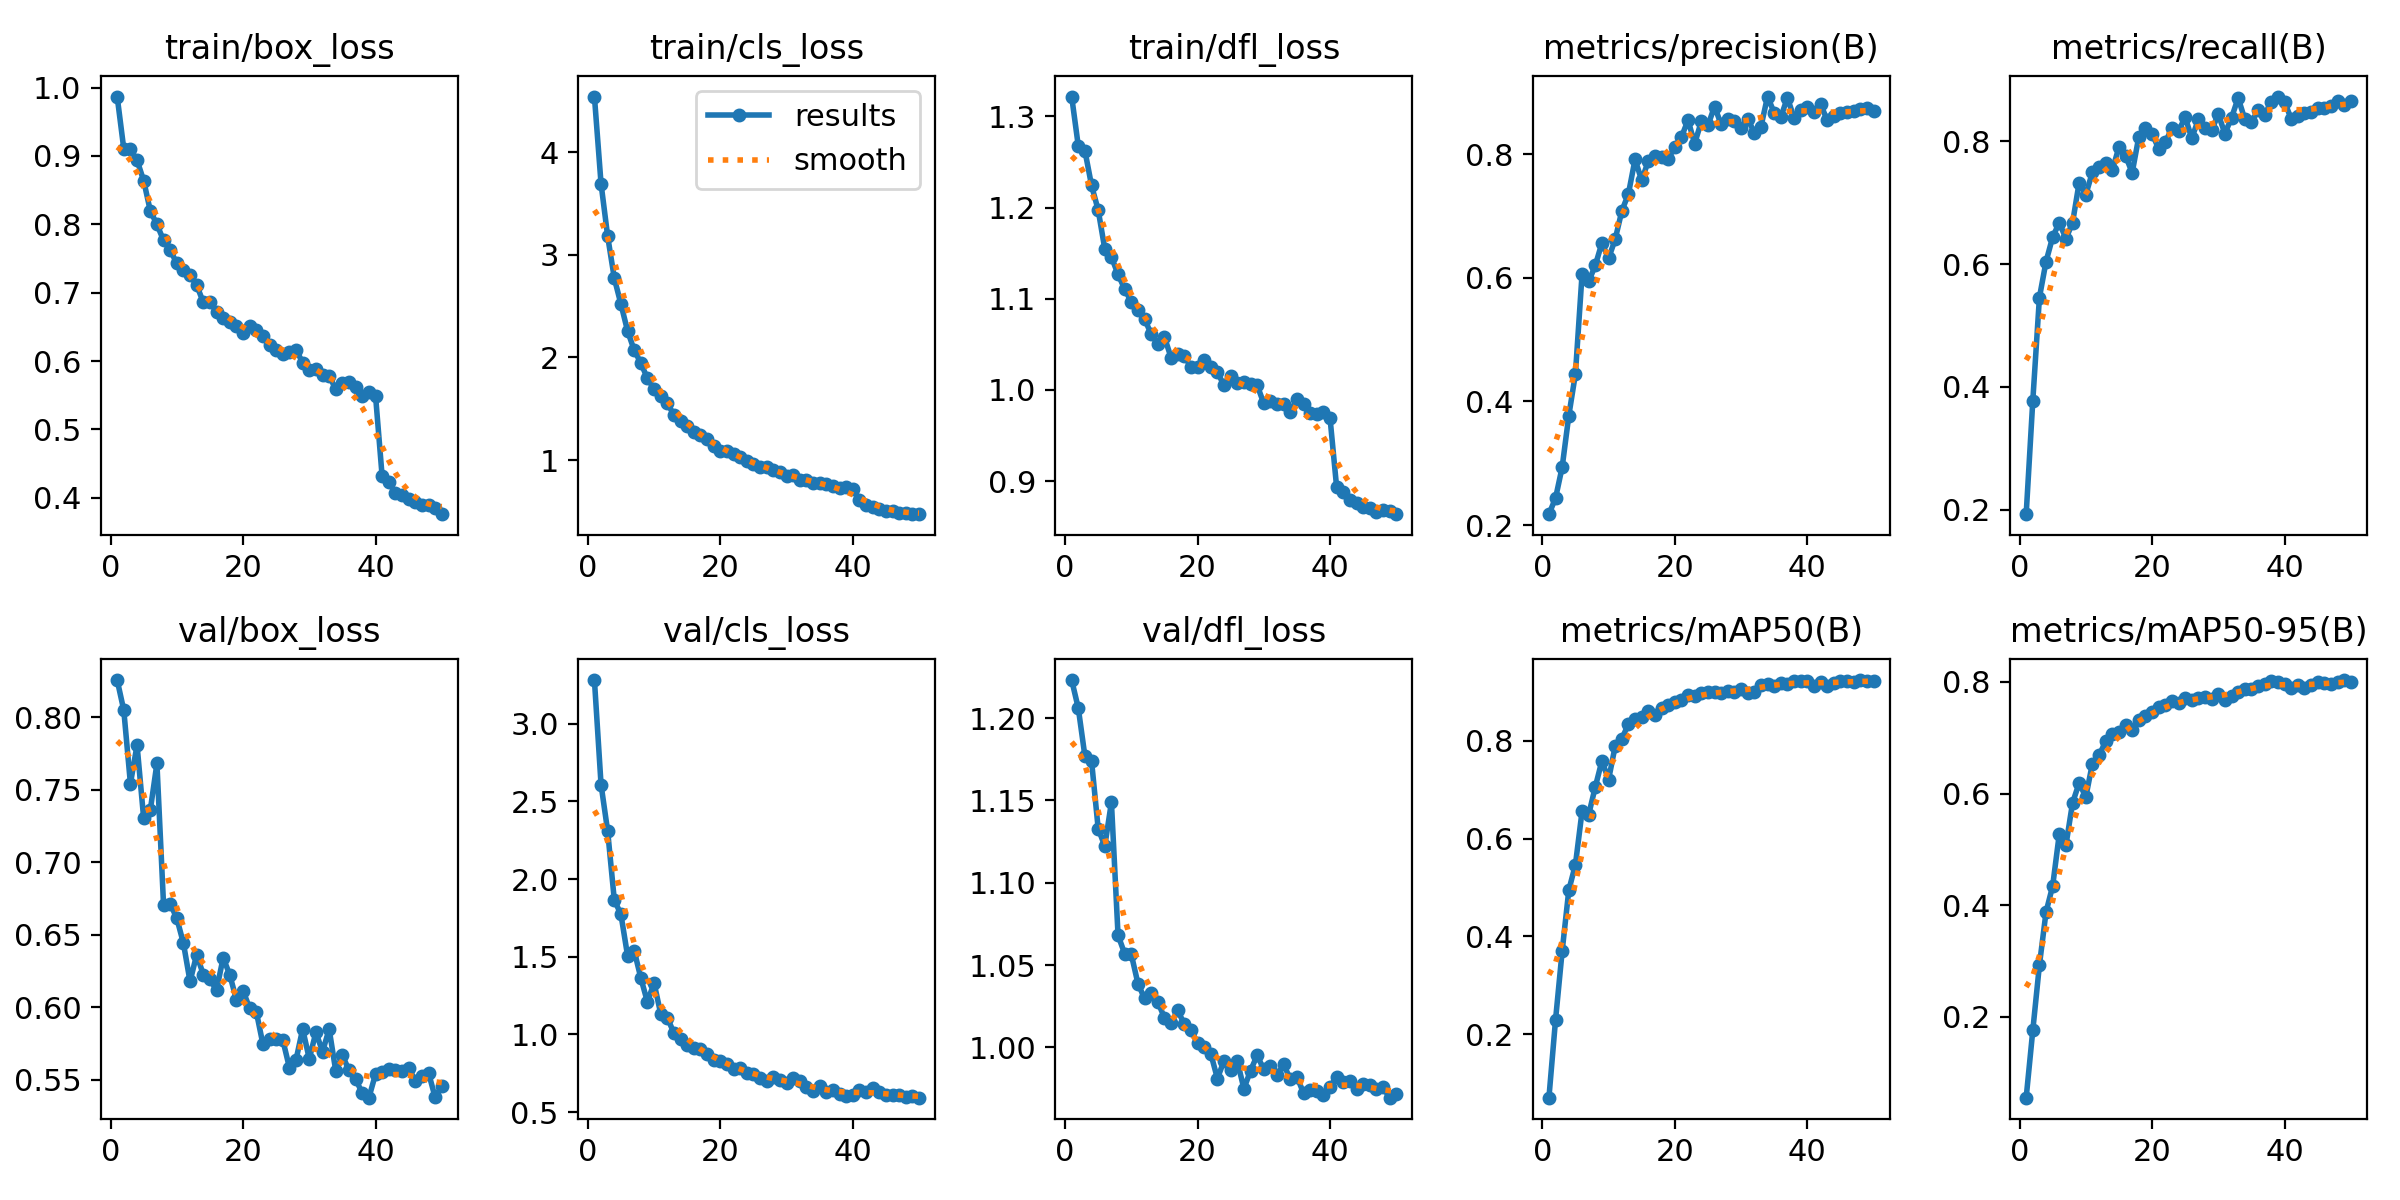

In [33]:
from IPython.display import Image
Image("./runs/detect/train/results.png")

In [40]:
import os
import random

imgs = []
dir = 'datasets/YOLO_data/test/images'
for i in range(10):
    filename = random.choice(os.listdir(dir))
    path = os.path.join(dir, filename)
    imgs.append(path)

In [42]:
testing = model(imgs)


0: 640x640 1 dog-english_cocker_spaniel, 11.9ms
1: 640x640 1 cat-Egyptian_Mau, 11.9ms
2: 640x640 1 dog-beagle, 11.9ms
3: 640x640 1 dog-scottish_terrier, 11.9ms
4: 640x640 1 dog-chihuahua, 1 dog-miniature_pinscher, 11.9ms
5: 640x640 1 dog-keeshond, 1 dog-leonberger, 11.9ms
6: 640x640 1 dog-pomeranian, 11.9ms
7: 640x640 1 dog-english_cocker_spaniel, 11.9ms
8: 640x640 1 cat-Abyssinian, 11.9ms
9: 640x640 1 cat-Bombay, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


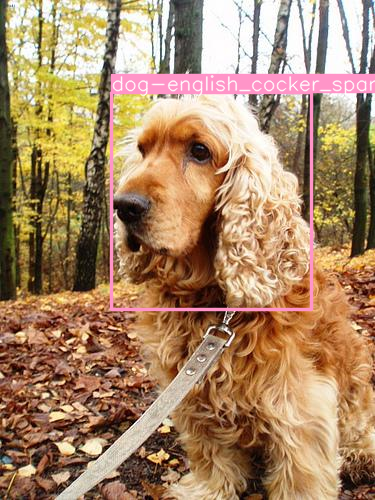

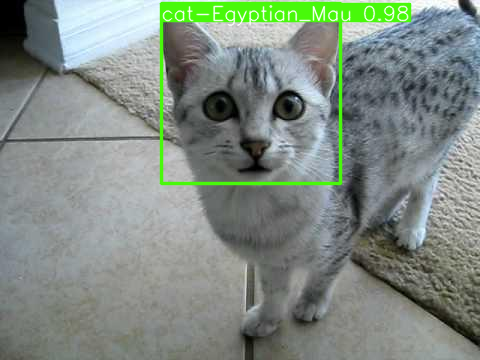

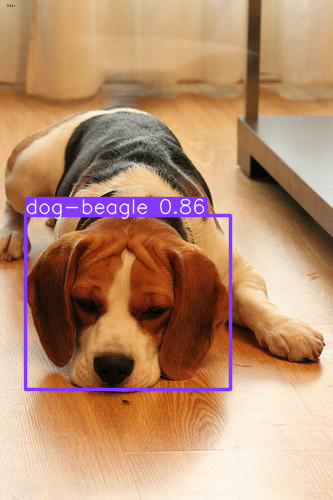

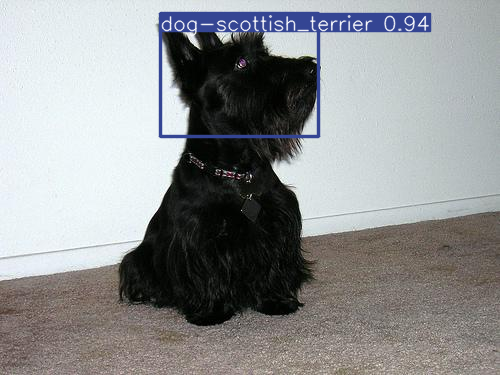

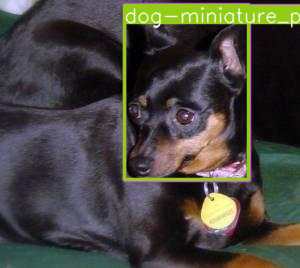

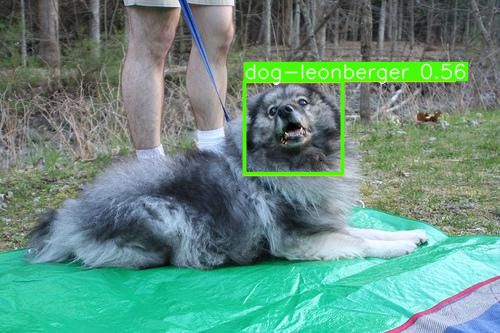

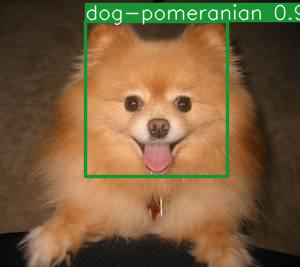

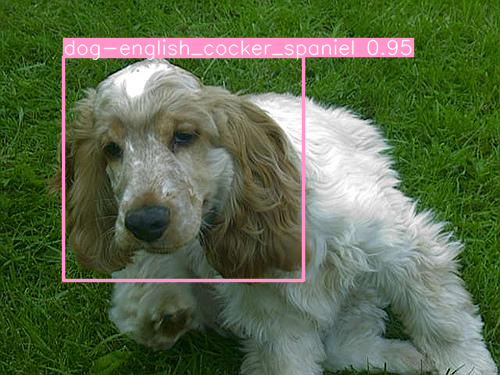

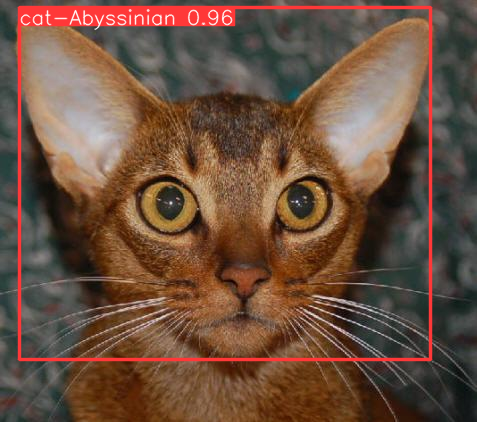

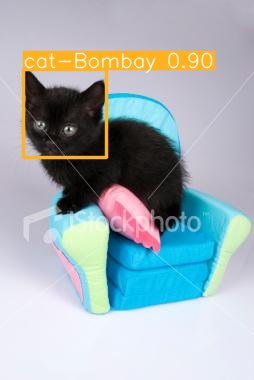

In [43]:
for img in testing:
    img.show()